# **Activity 11.1 Generate Images with DCGAN**


In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Note: not using Google CoLab


## **Import needed libraries**

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import InputLayer, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import zipfile
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt
from skimage.io import imread

In [3]:
def time_string(sec_elapsed):
    hour = int(sec_elapsed / (60 * 60))
    minute = int((sec_elapsed % (60 * 60)) / 60)
    second = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(hour, minute, second)


In [4]:
gen_res = 3 
gen_square = 32 * gen_res
img_chan = 3
img_rows = 5
img_cols = 5
img_margin = 16
seed_vector = 200
data_path = 'banana-or-orange/training_set/'
epochs = 500
num_batch = 32
num_buffer = 60000

print(f"Will generate a resolution of {gen_res}.")
print(f"Will generate {gen_square}px square images.")
print(f"Will generate {img_chan} image channels.")
print(f"Will generate {img_rows} preview rows.")
print(f"Will generate {img_cols} preview columns.")
print(f"Our preview margin equals {img_margin}.")
print(f"Our data path is: {data_path}.")
print(f"Our number of epochs are: {epochs}.")
print(f"Will generate a batch size of {num_batch}.")
print(f"Will generate a buffer size of {num_buffer}.")


Will generate a resolution of 3.
Will generate 96px square images.
Will generate 3 image channels.
Will generate 5 preview rows.
Will generate 5 preview columns.
Our preview margin equals 16.
Our data path is: banana-or-orange/training_set/.
Our number of epochs are: 500.
Will generate a batch size of 32.
Will generate a buffer size of 60000.


In [5]:
training_binary_path = os.path.join(data_path,
                                    f'training_data_{gen_square}_{gen_square}.npy')

print(f"Looking for file: {training_binary_path}")

if not os.path.isfile(training_binary_path):
    start = time.time()
    print("Loading training images...")

    train_data = []
    images_path = os.path.join(data_path,'banana')
    for filename in tqdm(os.listdir(images_path)):
        path = os.path.join(images_path,filename)
        images = Image.open(path).resize((gen_square,
            gen_square),Image.ANTIALIAS)
        train_data.append(np.asarray(images))
    train_data = np.reshape(train_data,(-1,gen_square,
              gen_square,img_chan))
    train_data = train_data.astype(np.float32)
    train_data = train_data / 127.5 - 1.

    print("Saving training image binary...")
    np.save(training_binary_path,train_data)
    elapsed = time.time()-start
    print (f'Image preprocess time: {time_string(elapsed)}')
else:
    print("Loading training data...")
    train_data = np.load(training_binary_path)


Looking for file: banana-or-orange/training_set/training_data_96_96.npy
Loading training data...


In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_data) \
    .shuffle(num_buffer).batch(num_batch)


2021-10-18 18:40:08.376503: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
def create_dc_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
   
    # Output resolution, additional upsampling
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    if gen_res>1:
        model.add(UpSampling2D(size=(gen_res,gen_res)))
        model.add(Conv2D(128,kernel_size=3,padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))

    # Final CNN layer
    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model

def create_dc_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

def create_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(96*96*3,activation="tanh",input_dim=seed_size))
    model.add(Reshape((96,96,3)))

    return model

def create_discriminator(img_size):
    model = Sequential()
    model.add(InputLayer(input_shape=img_size))
    model.add(Dense(1024, activation="tanh"))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model


In [8]:
def save_images(generator, cnt, noise, prefix=None):
    img_array = np.full(( 
      img_margin + (img_rows * (gen_square+img_margin)), 
      img_margin + (img_cols * (gen_square+img_margin)), 3), 
      255, dtype=np.uint8)
  
    gen_imgs = generator.predict(noise)

    gen_imgs = 0.5 * gen_imgs + 0.5

    img_count = 0
    for row in range(img_rows):
        for col in range(img_cols):
            r = row * (gen_square+16) + img_margin
            c = col * (gen_square+16) + img_margin
            img_array[r:r+gen_square,c:c+gen_square] \
                = gen_imgs[img_count] * 255
            img_count += 1

          
    output_path = os.path.join(data_path,'output')
    if not os.path.exists(output_path):
        os.makedirs(output_path)
  
    filename = os.path.join(output_path,f"train{prefix}-{cnt}.png")
    im = Image.fromarray(img_array)
    im.save(filename)


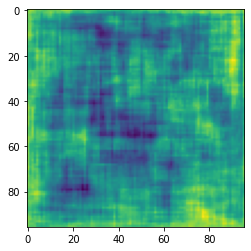

In [9]:
dc_generator = create_dc_generator(seed_vector, img_chan)

noise = tf.random.normal([1, seed_vector])
gen_img = dc_generator(noise, training=False)

plt.imshow(gen_img[0, :, :, 0])

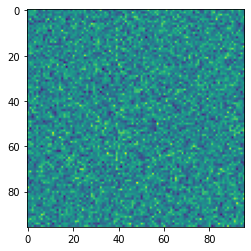

In [10]:
generator = create_generator(seed_vector, img_chan)
gen_van_img = generator(noise, training=False)
plt.imshow(gen_van_img[0, :, :, 0])

In [11]:
img_shape = (gen_square,gen_square,img_chan)

dc_discriminator = create_dc_discriminator(img_shape)
dc_decision = dc_discriminator(gen_img)
print(dc_decision)


tf.Tensor([[0.4996997]], shape=(1, 1), dtype=float32)


In [12]:
discriminator = create_discriminator(img_shape)
decision = discriminator(gen_img)
print(decision)

tf.Tensor([[0.49596092]], shape=(1, 1), dtype=float32)


In [13]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discrim_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def gen_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [14]:
gen_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
disc_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)


In [15]:
#@tf.function
def train_step(generator, discriminator, images):
    seed = tf.random.normal([num_batch, seed_vector])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_imgs = generator(seed, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(gen_imgs, training=True)

        g_loss = gen_loss(fake_output)
        d_loss = discrim_loss(real_output, fake_output)


        gradients_of_generator = gen_tape.gradient(\
            g_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(\
            d_loss, discriminator.trainable_variables)

        gen_optimizer.apply_gradients(zip(
            gradients_of_generator, generator.trainable_variables))
        disc_optimizer.apply_gradients(zip(
            gradients_of_discriminator, 
            discriminator.trainable_variables))
    return g_loss,d_loss


In [16]:
def train(generator, discriminator, dataset, epochs, prefix=None):
    fixed_seed = np.random.normal(0, 1, (img_rows * img_cols, 
                                       seed_vector))
    start = time.time()

    for epoch in range(epochs):
        epoch_start = time.time()

        g_loss_list = []
        d_loss_list = []

        for image_batch in dataset:
            t = train_step(generator, discriminator, image_batch)
            g_loss_list.append(t[0])
            d_loss_list.append(t[1])

        generator_loss = sum(g_loss_list) / len(g_loss_list)
        discriminator_loss = sum(d_loss_list) / len(d_loss_list)

        epoch_elapsed = time.time()-epoch_start
        if (epoch + 1) % 100 == 0:
            print (f'Epoch {epoch+1}, gen loss={generator_loss},disc loss={discriminator_loss},'\
               f' {time_string(epoch_elapsed)}')
            save_images(generator, epoch,fixed_seed, prefix=prefix)

    elapsed = time.time()-start
    print (f'Training time: {time_string(elapsed)}')


In [ ]:
train(dc_generator, dc_discriminator, train_dataset, epochs, prefix='-dc-gan')

In [18]:
train(generator, discriminator, train_dataset, epochs, prefix='-vanilla')

Epoch 100, gen loss=311.2907409667969,disc loss=5.356048035016787e-38, 0:00:19.57
Epoch 200, gen loss=309.8463134765625,disc loss=1.737192860673531e-07, 0:00:18.24
Epoch 300, gen loss=293.5929870605469,disc loss=6.873465796530809e-09, 0:00:31.75
Epoch 400, gen loss=250.16270446777344,disc loss=2.5418545432944015e-25, 0:00:16.89
Epoch 500, gen loss=193.46173095703125,disc loss=1.6637796689967066e-17, 0:00:18.79
Training time: 13:04:08.23


In [ ]:
dcgan_499 = imread('banana-or-orange/training_set/output/train-dc-gan-499.png')
plt.imshow(dcgan_499)

In [19]:
vanilla_499 = imread('banana-or-orange/training_set/output/train-vanilla-499.png')
plt.imshow(vanilla_499)


FileNotFoundError: No such file: '/Users/moocarmm/OneDrive - Viacom/OneDrive - ViacomCBS/TensorflowWorkshop/Code/Chapter11/Activity11.01/banana-or-orange/training_set/output/trainvanilla-99.png'